Відсоток кількості поїздок, оплачених кожним із типів оплат по днях місяцях

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

spark = SparkSession.builder \
    .appName("SimpleApp") \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
25/04/15 13:21:35 WARN Utils: Your hostname, DESKTOP-DP2FLCF resolves to a loopback address: 127.0.1.1; using 172.22.104.161 instead (on interface eth0)
25/04/15 13:21:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/15 13:21:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df_fare_init = spark.read.option("header", True).option("inferSchema", True).csv("../data_lake/trip_fare_1.csv")
df_trip_init = spark.read.option("header", True).option("inferSchema", True).csv("../data_lake/trip_data_1.csv")

In [3]:
for column in df_fare_init.columns:
    df_fare_init = df_fare_init.withColumnRenamed(column, column.strip().replace(" ", "_"))

In [4]:
from pyspark.sql.functions import to_date, lit

df_trip = df_trip_init.filter(
    (col("passenger_count") > 0) & (col("passenger_count") <= 10) &
    (col("trip_time_in_secs") > 0) &
    (col("trip_distance") > 0) &
    (col("pickup_latitude").between(40.5, 41.0)) &
    (col("dropoff_latitude").between(40.5, 41.0)) &
    (col("pickup_longitude").between(-74.5, -73.0)) &
    (col("dropoff_longitude").between(-74.5, -73.0)) &
    (col("pickup_datetime") <= lit("2013-01-27"))
)

df_fare = df_fare_init.filter(
    (col("fare_amount") >= 0) &
    (col("tip_amount") >= 0) &
    (col("tolls_amount") >= 0) &
    (col("total_amount") >= 0) &
    ((col("fare_amount") > 0) | (col("payment_type") == "NOC")) &
    (col("pickup_datetime") <= lit("2013-01-27"))
)

In [ ]:
from pyspark.sql.functions import max, min, col, to_date, trunc

df = df_trip.join(df_fare, on=["medallion", "hack_license", "pickup_datetime", "vendor_id"])

In [6]:
from pyspark.sql.functions import col, hour, when, to_date, max as Fmax, date_sub, expr, avg, round as Fround
from pyspark.sql.functions import col, to_date, max as Fmax, date_sub, sum as Fsum


In [ ]:
from pyspark.sql.functions import col, to_date, count, sum as Fsum, round
from pyspark.sql.window import Window

df_with_date = df.withColumn("trip_date", to_date("pickup_datetime"))

df_payment_count = df_with_date.groupBy("trip_date", "payment_type").agg(
    count("*").alias("ride_count")
)

window_spec = Window.partitionBy("trip_date")
df_with_total = df_payment_count.withColumn(
    "total_rides_per_day", Fsum("ride_count").over(window_spec)
)

df_payment_share = df_with_total.withColumn(
    "payment_share", round(col("ride_count") / col("total_rides_per_day"), 3)
)

df_pivoted = df_payment_share.groupBy("trip_date").pivot("payment_type").agg(
    round(Fsum("payment_share"), 3)
).orderBy("trip_date")


25/04/15 13:27:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 13:27:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 13:27:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 13:27:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 13:27:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 13:27:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 13:27:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 13:27:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 13:27:35 WARN RowBasedKeyValueBatch: Calling spill() on

In [8]:
df_pivoted = df_pivoted.fillna(0)
df_pivoted.show(30, truncate=False)


25/04/15 13:29:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 13:29:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 13:29:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 13:29:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 13:29:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 13:29:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 13:29:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 13:29:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/15 13:29:02 WARN RowBasedKeyValueBatch: Calling spill() on

+----------+-----+-----+-----+-----+-----+
|trip_date |CRD  |CSH  |DIS  |NOC  |UNK  |
+----------+-----+-----+-----+-----+-----+
|2013-01-01|0.416|0.58 |0.001|0.002|0.0  |
|2013-01-02|0.449|0.548|0.001|0.002|0.0  |
|2013-01-03|0.487|0.51 |0.001|0.002|0.0  |
|2013-01-04|0.526|0.472|0.001|0.001|0.0  |
|2013-01-05|0.547|0.451|0.0  |0.001|0.0  |
|2013-01-06|0.564|0.434|0.0  |0.001|0.0  |
|2013-01-07|0.653|0.343|0.001|0.002|0.0  |
|2013-01-08|0.656|0.341|0.001|0.002|0.0  |
|2013-01-09|0.59 |0.406|0.001|0.003|0.0  |
|2013-01-10|0.632|0.364|0.001|0.003|0.0  |
|2013-01-11|0.567|0.429|0.001|0.003|0.0  |
|2013-01-12|0.556|0.44 |0.001|0.003|0.0  |
|2013-01-13|0.525|0.472|0.001|0.002|0.0  |
|2013-01-14|0.539|0.459|0.001|0.002|0.0  |
|2013-01-15|0.555|0.443|0.001|0.001|0.0  |
|2013-01-16|0.567|0.431|0.001|0.001|0.0  |
|2013-01-17|0.58 |0.417|0.001|0.001|0.0  |
|2013-01-18|0.648|0.351|0.0  |0.001|0.0  |
|2013-01-19|0.661|0.338|0.0  |0.0  |0.0  |
|2013-01-20|0.676|0.324|0.0  |0.0  |0.0  |
|2013-01-21

<Figure size 1400x600 with 0 Axes>

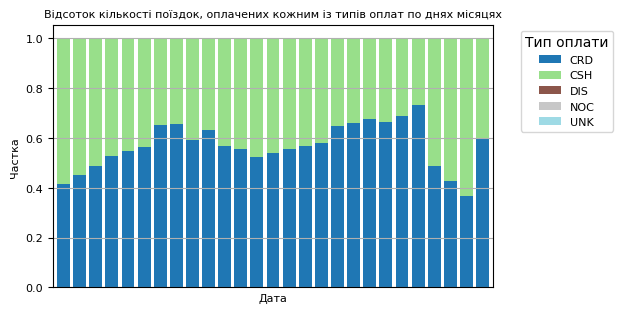

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pdf = df_pivoted.toPandas()

pdf["trip_date"] = pd.to_datetime(pdf["trip_date"])
pdf = pdf.sort_values("trip_date")

pdf.set_index("trip_date", inplace=True)

plt.figure(figsize=(14, 6))
ax = pdf.plot(kind="bar", stacked=True, colormap="tab20", width=0.8)

plt.title("Відсоток кількості поїздок, оплачених кожним із типів оплат по днях місяцях", fontsize=8)
plt.xlabel("Дата", fontsize=8)
plt.ylabel("Частка", fontsize=8)

plt.legend(title="Тип оплати", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.grid(axis="y")

plt.xticks([])
plt.tick_params(axis="both", labelsize=8)

plt.show()


<Figure size 1200x600 with 0 Axes>

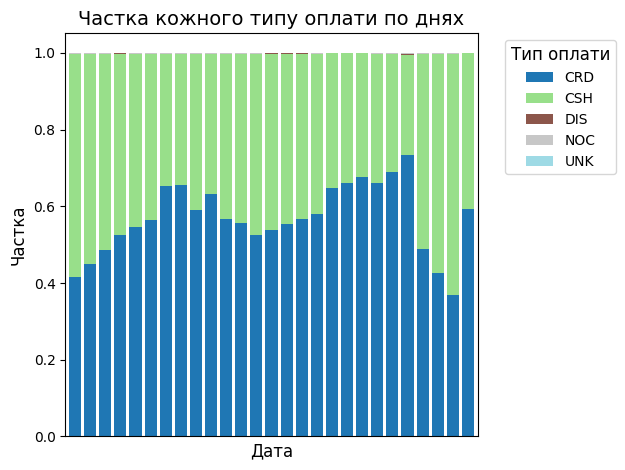

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pdf = df_pivoted.toPandas()

pdf["trip_date"] = pd.to_datetime(pdf["trip_date"])
pdf = pdf.sort_values("trip_date")

pdf.set_index("trip_date", inplace=True)

plt.figure(figsize=(12, 6))
pdf.plot(kind="bar", stacked=True, colormap="tab20", width=0.8)

plt.title("Частка кожного типу оплати по днях", fontsize=14)
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Частка", fontsize=12)

plt.legend(title="Тип оплати", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

plt.xticks([], rotation=45)

plt.tick_params(axis="both", labelsize=10)

plt.tight_layout()

plt.savefig("payment_types_per_day_high_res.png", dpi=300, bbox_inches='tight')

plt.show()
